<a href="https://colab.research.google.com/github/sheelapravalika/sheela2000.drdo/blob/main/IF%2BRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# ✅ Install (Colab)
!pip install -q datasets pandas scikit-learn matplotlib seaborn

In [18]:

# ✅ Imports
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [19]:
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary")
df = dataset["train"].to_pandas()

# Encode Label (Benign=0, Attack=1)
df["Label"] = (df["Label"] != "BENIGN").astype(int)

# Keep only numeric features (drop string cols like LabelMap)
X_all = df.drop("Label", axis=1).select_dtypes(include=["int64", "float64"])
y_all = df["Label"].values


In [20]:
target_n = 80_000
ben = df[df["Label"] == 0]
atk  = df[df["Label"] == 1]

ben_n = min(len(ben), target_n)
atk_n = min(len(atk), target_n)

ben_s = ben.sample(n=ben_n, random_state=42)
atk_s = atk.sample(n=atk_n, random_state=42)

df_sample = pd.concat([ben_s, atk_s]).sample(frac=1, random_state=42)  # shuffle

X = df_sample.drop("Label", axis=1).select_dtypes(include=["int64", "float64"])
y = df_sample["Label"].values

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_comp = min(60, X_scaled.shape[1])  # safety if <60 features after cleaning
pca = PCA(n_components=n_comp, random_state=42)
X_pca = pca.fit_transform(X_scaled)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# =============================
# 5) Small Grid over IsolationForest to hit ~96%
#    - We’ll add IF anomaly score + IF label as 2 extra features
#    - RF is supervised classifier
# =============================
contamination_grid = [0.03, 0.04, 0.05, 0.06]
n_estimators_grid  = [150, 200]

In [23]:
best = {"acc": -1, "params": None, "report": None, "cm": None}

for cont in contamination_grid:
    for n_est in n_estimators_grid:
        # Isolation Forest (unsupervised)
        iso = IsolationForest(
            n_estimators=n_est,
            max_samples=0.8,
            contamination=cont,
            max_features=0.8,
            random_state=42,
            n_jobs=-1
        )
        iso.fit(X_train)

In [32]:
        # Anomaly signals
        tr_scores = iso.decision_function(X_train).reshape(-1,1)
        te_scores = iso.decision_function(X_test).reshape(-1,1)
        tr_labels = iso.predict(X_train).reshape(-1,1)   # {1 normal, -1 anomaly}
        te_labels = iso.predict(X_test).reshape(-1,1)

        # Map IF labels to {0:normal, 1:anomaly}
        tr_labels = np.where(tr_labels == 1, 0, 1)
        te_labels = np.where(te_labels == 1, 0, 1)

        # Hybrid features = PCA comps + IF score + IF label
        X_train_h = np.hstack([X_train, tr_scores, tr_labels])
        X_test_h  = np.hstack([X_test,  te_scores, te_labels])

        # Supervised RF
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=4,
            min_samples_leaf=2,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train_h, y_train)
        y_pred = rf.predict(X_test_h)
        acc = accuracy_score(y_test, y_pred)

        if acc > best["acc"]:
            best["acc"] = acc
            best["params"] = {"contamination": cont, "n_estimators_if": n_est}
            best["report"] = classification_report(y_test, y_pred, digits=4)
            best["cm"] = confusion_matrix(y_test, y_pred)
            best["rf"] = rf


In [33]:
print("✅ Best Accuracy:", f"{best['acc']:.4f}")
print("✅ Best IF Params:", best["params"])
print("\n📄 Classification Report (best):\n", best["report"])
print("\n📊 Confusion Matrix (best):\n", best["cm"])

✅ Best Accuracy: 0.9977
✅ Best IF Params: {'contamination': 0.06, 'n_estimators_if': 200}

📄 Classification Report (best):
               precision    recall  f1-score   support

           0     0.9970    0.9984    0.9977     16000
           1     0.9984    0.9970    0.9977     16000

    accuracy                         0.9977     32000
   macro avg     0.9977    0.9977    0.9977     32000
weighted avg     0.9977    0.9977    0.9977     32000


📊 Confusion Matrix (best):
 [[15974    26]
 [   48 15952]]


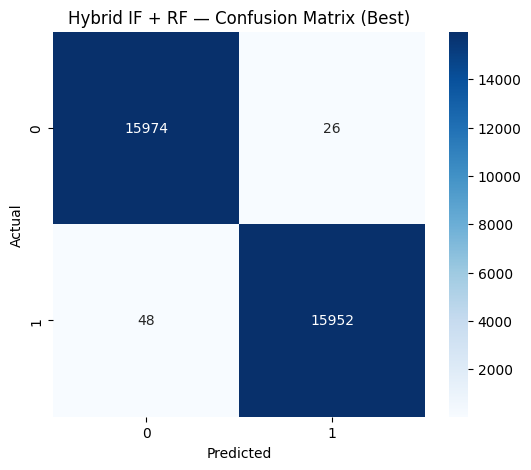

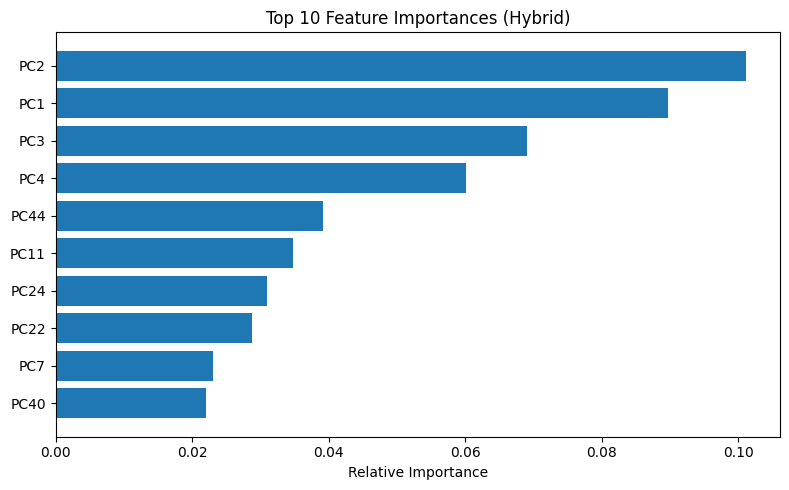

In [34]:
# =============================
# 6) Visualization (Confusion Matrix + Top Feature Importances)
# =============================
plt.figure(figsize=(6,5))
sns.heatmap(best["cm"], annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Hybrid IF + RF — Confusion Matrix (Best)")
plt.show()

# RF feature importances: name PCA comps + IF signals
feat_names = [f"PC{i+1}" for i in range(n_comp)] + ["iso_score", "iso_label"]
importances = best["rf"].feature_importances_
idx = np.argsort(importances)[-10:]  # top 10

plt.figure(figsize=(8,5))
plt.barh(range(len(idx)), importances[idx], align="center")
plt.yticks(range(len(idx)), [feat_names[i] for i in idx])
plt.xlabel("Relative Importance")
plt.title("Top 10 Feature Importances (Hybrid)")
plt.tight_layout()
plt.show()